In [3]:
import numpy as np
import pandas as pd 
import fbprophet 
from fbprophet import Prophet
import plotly
import statsmodels
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
import altair as alt
import scipy
from scipy import signal
import spectrum 
from spectrum import WelchPeriodogram
from spectrum import Periodogram
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import q_stat
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from math import sqrt
import warnings
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [4]:
flu_data = pd.read_csv('flu.csv', header = 2, sep = ',')

In [5]:
flu_data.head(10)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,0.0,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,0.0,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,0.0,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,0.0,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,0.0,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak
5,United States of America,Region of the Americas of WHO,North America,2013,6,2013-02-04,2013-02-10,13259,13259,0.0,...,0.0,706,2008,0,0,1051,1051,3059,NaN,Widespread Outbreak
6,United States of America,Region of the Americas of WHO,North America,2013,7,2013-02-11,2013-02-17,11468,11468,0.0,...,0.0,486,1353,0,0,1032,1032,2385,NaN,Widespread Outbreak
7,United States of America,Region of the Americas of WHO,North America,2013,8,2013-02-18,2013-02-24,10398,10398,0.0,...,0.0,363,985,0,0,1084,1084,2069,NaN,Widespread Outbreak
8,United States of America,Region of the Americas of WHO,North America,2013,9,2013-02-25,2013-03-03,9499,9499,0.0,...,0.0,289,730,0,0,1046,1046,1776,NaN,Widespread Outbreak
9,United States of America,Region of the Americas of WHO,North America,2013,10,2013-03-04,2013-03-10,8999,8999,0.0,...,0.0,200,562,0,0,1083,1083,1645,NaN,Regional Outbreak


In [6]:
#Percentages of positive results
flu_data["pct_positive"]=round((flu_data["ALL_INF"]/flu_data["SPEC_PROCESSED_NB"])*100,2)

In [7]:
flu_data.head(10)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE,pct_positive
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak,35.53
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak,34.46
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak,30.87
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak,29.93
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak,27.30
5,United States of America,Region of the Americas of WHO,North America,2013,6,2013-02-04,2013-02-10,13259,13259,0.0,...,706,2008,0,0,1051,1051,3059,NaN,Widespread Outbreak,23.07
6,United States of America,Region of the Americas of WHO,North America,2013,7,2013-02-11,2013-02-17,11468,11468,0.0,...,486,1353,0,0,1032,1032,2385,NaN,Widespread Outbreak,20.80
7,United States of America,Region of the Americas of WHO,North America,2013,8,2013-02-18,2013-02-24,10398,10398,0.0,...,363,985,0,0,1084,1084,2069,NaN,Widespread Outbreak,19.90
8,United States of America,Region of the Americas of WHO,North America,2013,9,2013-02-25,2013-03-03,9499,9499,0.0,...,289,730,0,0,1046,1046,1776,NaN,Widespread Outbreak,18.70
9,United States of America,Region of the Americas of WHO,North America,2013,10,2013-03-04,2013-03-10,8999,8999,0.0,...,200,562,0,0,1083,1083,1645,NaN,Regional Outbreak,18.28


## Utility Functions

In [8]:
def arima_window_ase(data_series, train_ratio = .60, order = (0,0,0)): 
    X_series = data_series.values
    size = int(len(X_series)*train_ratio)
    train,test = X_series[0:size], X_series[size:len(X_series)]
    history = [i for i in train]
    preds = list()
    for t in range(len(test)): 
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        fore_cast = model_fit.forecast()
        yhat = fore_cast[0]
        preds.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, preds))
    pyplot.plot(test)
    pyplot.plot(preds, color='red')
    pyplot.show()
    
    return rmse
    print(residuals.describe())

In [9]:

def arima_seas_window_ase(data_series, train_ratio = .60, order = (0,0,0), seasonal_order = (0,0,0,0),simple_differencing=True): 
    X_series = data_series.values
    size = int(len(X_series)*train_ratio)
    train,test = X_series[0:size], X_series[size:len(X_series)]
    history = [i for i in train]
    preds = list()
    for t in range(len(test)): 
        model = ARIMA(history, order=order)
        model = sm.tsa.statespace.SARIMAX(history, order=order, seasonal_order=seasonal_order,simple_differencing=simple_differencing) 
        model_fit = model.fit()
        fore_cast = model_fit.forecast()
        yhat = fore_cast[0]
        preds.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, preds))
    pyplot.plot(test)
    pyplot.plot(preds, color='red')
    pyplot.show()
    
    return rmse
    print(residuals.describe())

In [10]:

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [11]:
def make_realization(data_frame,x,y): 
    
    vis = alt.Chart(data_frame).mark_line().encode(
    x = x, 
    y = y
    )
    
    return vis

In [12]:
def make_autocorr(data_series, nlags=40, fft = False): 
    auto_corr = statsmodels.tsa.stattools.acf(data_series, nlags=nlags, fft=fft)
    data = pd.DataFrame(list(enumerate(auto_corr)), columns = ['Lag', 'AutoCor'])
    vis = alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
    )
    return vis

In [13]:
def make_sig_periodgram(data_series, fs = 1, scaling = 'density'): 
    f, Pxx_den = scipy.signal.periodogram(data_series, fs = fs, scaling=scaling)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [14]:
def make_welch_sig_periodgram(data_series, fs = 1, nperseg=50): 
    f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=nperseg)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [15]:
def make_welch_periodgram(data_series, sampling = 50):
    psd = WelchPeriodogram(data_series, sampling)
    return psd[1]

In [16]:
#Based on spec_received
make_realization(flu_data, 'EDATE:T', 'SPEC_RECEIVED_NB')

alt.Chart(...)

In [18]:
make_autocorr(flu_data.SPEC_RECEIVED_NB, nlags = 40)

alt.Chart(...)

In [19]:
SPEC_RECIEVD_NB_auto_cor = statsmodels.tsa.stattools.acf(flu_data.SPEC_RECEIVED_NB)

C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [20]:
data = pd.DataFrame(list(enumerate(SPEC_RECIEVD_NB_auto_cor)), columns = ['Lag', 'AutoCor'])
alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
)

alt.Chart(...)

In [21]:
make_sig_periodgram(flu_data.SPEC_RECEIVED_NB)

alt.Chart(...)

In [22]:
f, Pxx_den = scipy.signal.periodogram(flu_data.SPEC_RECEIVED_NB, fs = 1, scaling='density')

In [23]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

In [24]:
make_welch_sig_periodgram(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

alt.Chart(...)

In [25]:
f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

In [26]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

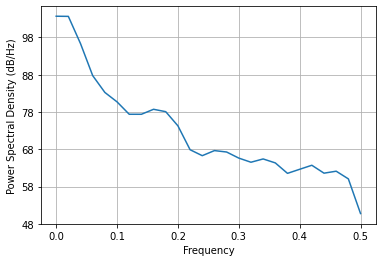

In [27]:
make_welch_periodgram(flu_data.SPEC_RECEIVED_NB,sampling = 50)

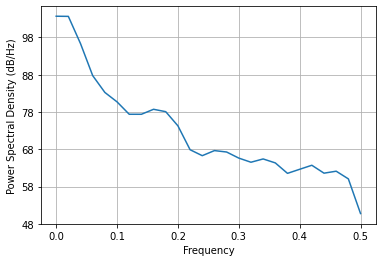

In [28]:
psd = WelchPeriodogram(flu_data.SPEC_RECEIVED_NB,50)

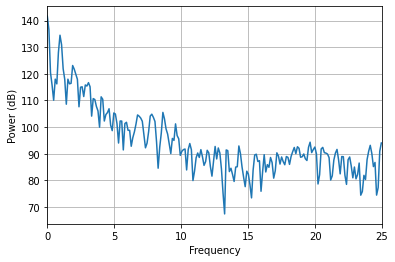

In [29]:
psd = Periodogram(flu_data.SPEC_RECEIVED_NB, 50, scale_by_freq = True)
psd.plot()

# Charts based on pct_positive
> pct_positive = (flu_data["ALL_INF"]/flu_data["SPEC_PROCESSED_NB"])*100

In [30]:
#Based on pct_positive
make_realization(flu_data, 'EDATE:T', 'pct_positive')


alt.Chart(...)

In [31]:
#pct_positive
alt.Chart(flu_data).mark_line().encode(
    x='EDATE:T',
    y='pct_positive'
)

alt.Chart(...)

In [32]:
#pct_positive
make_autocorr(flu_data.pct_positive, nlags = 40)

alt.Chart(...)

In [33]:
#pct_positive
pct_positive_auto_cor = statsmodels.tsa.stattools.acf(flu_data.pct_positive)

C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [34]:
#pct_positive_auto_cor
data = pd.DataFrame(list(enumerate(pct_positive_auto_cor)), columns = ['Lag', 'AutoCor'])
alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
)

alt.Chart(...)

In [35]:
#pct_positive
make_sig_periodgram(flu_data.pct_positive)

alt.Chart(...)

In [36]:
f2, Pxx_den2 = scipy.signal.periodogram(flu_data.pct_positive, fs = 1, scaling='density')

In [37]:
data = pd.DataFrame({'Freq' : f2,'Density' : Pxx_den2})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

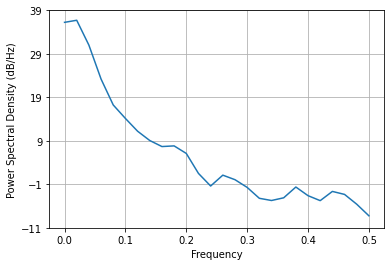

In [38]:
make_welch_periodgram(flu_data.pct_positive,sampling = 50)

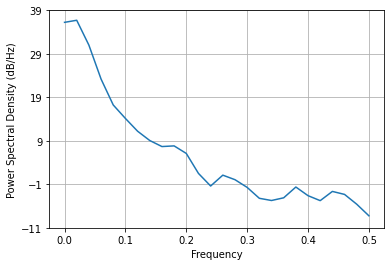

In [39]:
psd = WelchPeriodogram(flu_data.pct_positive,50)

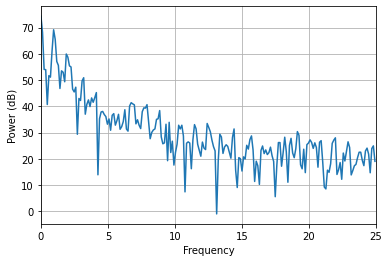

In [40]:
psd = Periodogram(flu_data.pct_positive, 50, scale_by_freq = True)
psd.plot()

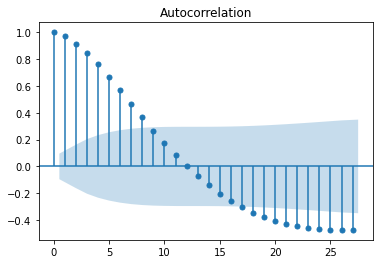

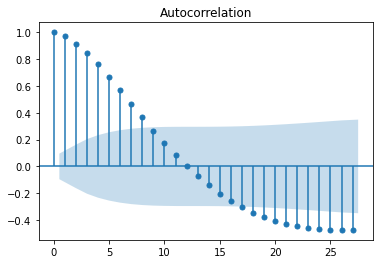

In [41]:
#acf plot

sm.graphics.tsa.plot_acf(flu_data.pct_positive)

In [54]:
dif_40 = statsmodels.tsa.statespace.tools.diff(flu_data.pct_positive,k_diff=0, k_seasonal_diff=40, seasonal_periods=1 )
dif_40

40     4.937752e+10
41    -1.039549e+10
42    -2.292025e+10
43     4.546358e+10
44    -5.629404e+10
           ...     
418    7.920024e+09
419   -1.239941e+10
420    1.586938e+10
421   -1.791559e+10
422    1.824039e+10
Name: pct_positive, Length: 383, dtype: float64

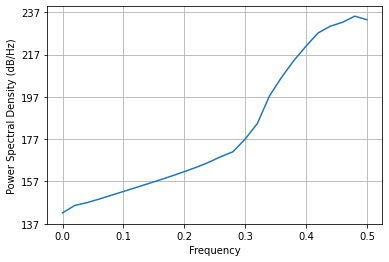

In [55]:

make_welch_periodgram(dif_40.values,sampling = 50)

In [56]:
#Auto Correlation Plot
make_autocorr(dif_40.values, nlags = 40)

alt.Chart(...)

In [57]:
#KPSS Test
kpss_test(dif_40)

Results of KPSS Test:
Test Statistic            0.035315
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Examine for seasonality

In [58]:
series = pd.Series(flu_data.pct_positive.values, index = flu_data.EDATE.astype('datetime64[ns]'), name = "Seasonal_Series")
series.describe()

count    423.000000
mean       9.364681
std        9.520811
min        0.050000
25%        2.325000
50%        4.440000
75%       15.035000
max       35.530000
Name: Seasonal_Series, dtype: float64

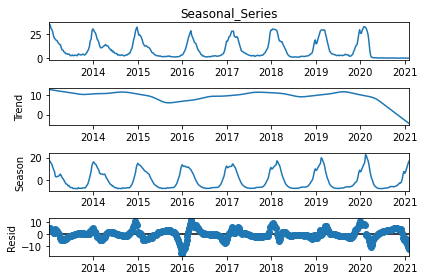

In [59]:
stl = STL(series, seasonal=41)
res = stl.fit()
fig = res.plot()

In [65]:
#Order determination assuming seasonality
res_seas = statsmodels.tsa.stattools.arma_order_select_ic(dif_40, ic=["aic", "bic"], trend="nc")

C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  retu

C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ign

In [66]:
res_seas.aic

,0,1,2
0,NaN,20196.812485,19685.219430
1,19644.451282,19139.387809,18639.562570
2,18763.260858,23127.507314,19155.843760
3,NaN,17515.085966,17768.825677
4,NaN,17998.207992,17560.914342


In [68]:
res_seas.aic_min_order

(3, 1)

In [69]:
res_seas.bic

,0,1,2
0,NaN,20204.708555,19697.063535
1,19652.347352,19151.231914,18655.354710
2,18775.104963,23143.299454,19175.583935
3,NaN,17534.826141,17792.513887
4,NaN,18021.896202,17588.550587


In [70]:
res_seas.bic_min_order

(3, 1)

# ARIMA using seasonality
>AIC and BIC both point to 3,1

                                     SARIMAX Results                                      
Dep. Variable:                     D.pct_positive   No. Observations:                  422
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 40)   Log Likelihood                -731.342
Date:                            Sun, 21 Feb 2021   AIC                           1472.685
Time:                                    10:09:53   BIC                           1492.910
Sample:                                         0   HQIC                          1480.677
                                            - 422                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6579      0.035     18.535      0.000       0.588       0.727
ar.L2      -9.293e-05      0.036   

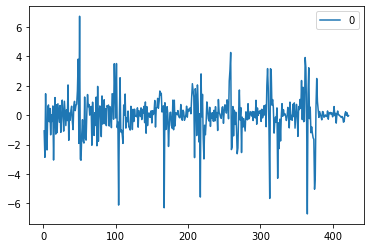

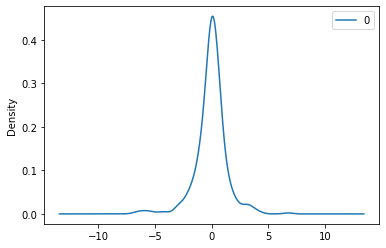

                0
count  422.000000
mean    -0.028300
std      1.369652
min     -6.709059
25%     -0.472987
50%      0.044036
75%      0.571983
max      6.713996


In [75]:
mod_seas = sm.tsa.statespace.SARIMAX(flu_data.pct_positive, order=(3,1,0), seasonal_order=(1,0,0,40), simple_differencing=True)
mod_seas_fit = mod_seas.fit()
# summary of fit model
print(mod_seas_fit.summary())
# line plot of residuals
residuals_seas = pd.DataFrame(mod_seas_fit.resid)
residuals_seas.plot()
pyplot.show()
# density plot of residuals
residuals_seas.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals_seas.describe())

In [76]:
sm.stats.acorr_ljungbox(mod_seas_fit.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.123769,0.276859


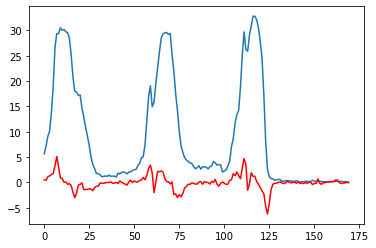

13.768855786032557

In [78]:

arima_seas_window_ase(flu_data.pct_positive, train_ratio = .60, order = (3,1,0), seasonal_order = (1,0,0,40),simple_differencing=True)

# ARIMA Model assuming stationarity

In [158]:
series = pd.Series(flu_data.pct_positive.values, index = flu_data.EDATE.astype('datetime64[ns]'), name = "Seasonal_Series")
series.describe()

count    423.000000
mean       9.364681
std        9.520811
min        0.050000
25%        2.325000
50%        4.440000
75%       15.035000
max       35.530000
Name: Seasonal_Series, dtype: float64

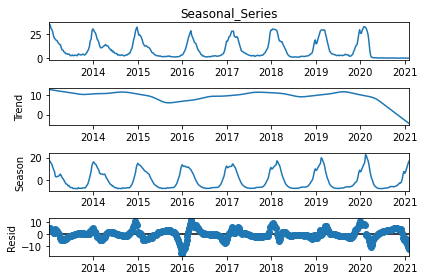

In [163]:

stl = STL(series, seasonal=41)
res = stl.fit()
fig = res.plot()

In [157]:
#Auto Correlation Plot
make_autocorr(flu_data.pct_positive.values, nlags = 500)

alt.Chart(...)

In [147]:
#KPSS Test
kpss_test(flu_data.pct_positive.values)

Results of KPSS Test:
Test Statistic            0.109822
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Accept H0 -- Trend is stationary

In [79]:
#Order determination assuming seasonality
res_seas = statsmodels.tsa.stattools.arma_order_select_ic(flu_data.pct_positive.values, ic=["aic", "bic"], trend="nc")

C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\seans\Anaconda3\envs\qtw\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.

In [80]:
res_seas.aic

,0,1,2
0,NaN,2849.506631,2436.656379
1,1738.738287,1563.309785,1513.459768
2,1473.484954,1473.566972,1473.501647
3,1473.928587,1473.839993,1476.148740
4,1474.345893,1475.181141,1477.455338


In [81]:
res_seas.aic_min_order

(2, 0)

In [82]:
res_seas.bic

,0,1,2
0,NaN,2857.601375,2448.798495
1,1746.833031,1575.451901,1529.649257
2,1485.627071,1489.756460,1493.738508
3,1490.118076,1494.076854,1500.432973
4,1494.582754,1499.465374,1505.786943


In [83]:
res_seas.bic_min_order

(2, 0)

In [107]:
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html?highlight=arima#statsmodels.tsa.arima.model.ARIMA
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Original was 5,1,0

model = ARIMA(flu_data.pct_positive.values, order=(2,0,0))
model_fit = model.fit()

In [108]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  423
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -728.259
Date:                Sun, 21 Feb 2021   AIC                           1464.519
Time:                        10:36:06   BIC                           1480.708
Sample:                             0   HQIC                          1470.916
                                - 423                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7563      3.148      3.099      0.002       3.587      15.926
ar.L1          1.6665      0.024     70.871      0.000       1.620       1.713
ar.L2         -0.6971      0.023    -30.028      0.000      -0.743      -0.652
sigma2         1.8120      0.070     25.786      0.000       1.674       1.950
===================================================================================
Ljung-Box (L1) (Q):                   2.38   Jarque-Bera (JB):               506.94
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.08
Prob(H) (two-sided):                  0.51   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

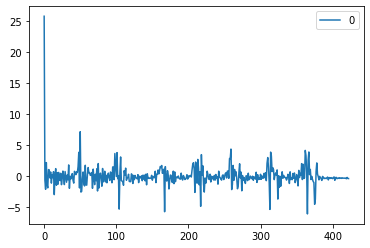

In [109]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

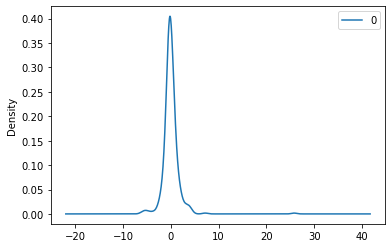

In [110]:
residuals.plot(kind='kde')
pyplot.show()

In [111]:
residuals.describe()

,0
count,423.000000
mean,0.023325
std,1.833395
min,-6.055178
25%,-0.536243
50%,-0.181773
75%,0.505245
max,25.773740


In [144]:
for i in range(1,40):
    print(sm.stats.acorr_ljungbox(model_fit.resid, lags=[i], return_df=True))

   lb_stat  lb_pvalue
1  1.04216    0.30732
    lb_stat  lb_pvalue
2  2.228517   0.328158
   lb_stat  lb_pvalue
3  2.94452   0.400258
    lb_stat  lb_pvalue
4  2.980977   0.561014
    lb_stat  lb_pvalue
5  3.235244   0.663769
    lb_stat  lb_pvalue
6  3.341408   0.764936
    lb_stat  lb_pvalue
7  4.593098    0.70948
   lb_stat  lb_pvalue
8  4.70961   0.788114
    lb_stat  lb_pvalue
9  5.180385   0.818309
     lb_stat  lb_pvalue
10  5.561161   0.850688
     lb_stat  lb_pvalue
11  5.665914     0.8947
     lb_stat  lb_pvalue
12  5.878423   0.922086
     lb_stat  lb_pvalue
13  5.878424   0.950466
     lb_stat  lb_pvalue
14  7.587689   0.909682
     lb_stat  lb_pvalue
15  7.671402    0.93628
     lb_stat  lb_pvalue
16  8.577746    0.92978
      lb_stat  lb_pvalue
17  10.851228   0.864192
      lb_stat  lb_pvalue
18  10.947438   0.896574
      lb_stat  lb_pvalue
19  13.167634    0.82988
     lb_stat  lb_pvalue
20  13.16975   0.869983
      lb_stat  lb_pvalue
21  13.185456   0.901989
      lb

#### No serial correlation

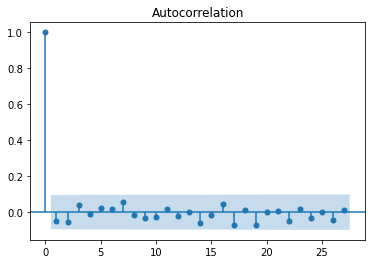

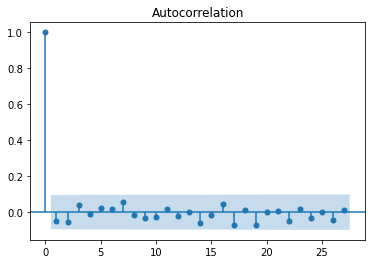

In [99]:
sm.graphics.tsa.plot_acf(residuals.values)

In [104]:
#Prediction
X = flu_data.pct_positive.values
size = int(len(X) * 0.60)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [105]:
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=5.875228, expected=5.640000
predicted=6.243627, expected=7.090000
predicted=8.140095, expected=9.030000
predicted=10.351253, expected=10.080000
predicted=10.786306, expected=13.670000
predicted=15.958258, expected=18.880000
predicted=22.160855, expected=26.620000
predicted=31.612166, expected=29.360000
predicted=30.711255, expected=29.350000
predicted=28.806449, expected=30.500000
predicted=30.745234, expected=30.020000
predicted=29.163295, expected=30.170000
predicted=29.757608, expected=29.730000
predicted=28.932703, expected=29.540000
predicted=28.929695, expected=28.460000
predicted=27.271710, expected=25.130000
predicted=22.470163, expected=20.740000
predicted=17.436609, expected=17.980000
predicted=15.891803, expected=17.820000
predicted=17.524359, expected=17.200000
predicted=16.610352, expected=17.220000
predicted=17.065510, expected=14.670000
predicted=12.844145, expected=12.870000
predicted=11.606095, expected=10.840000
predicted=9.476616, expected=9.210000
predicte

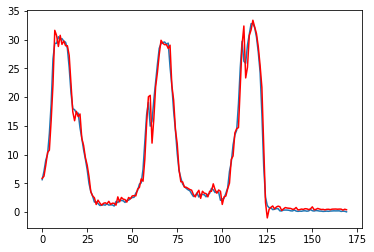

In [106]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

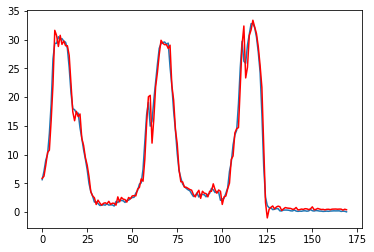

1.39463440066183

In [146]:

arima_window_ase(flu_data.pct_positive, train_ratio = .60, order=(2,0,0))

# Original using 5,1,0

In [84]:
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html?highlight=arima#statsmodels.tsa.arima.model.ARIMA
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Original was 5,1,0

model = ARIMA(flu_data.pct_positive.values, order=(5,1,0))
model_fit = model.fit()

In [85]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  423
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -733.086
Date:                Sun, 21 Feb 2021   AIC                           1478.172
Time:                        10:28:47   BIC                           1502.442
Sample:                             0   HQIC                          1487.763
                                - 423                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6490      0.033     19.392      0.000       0.583       0.715
ar.L2          0.0143      0.036      0.403      0.687      -0.055       0.084
ar.L3          0.0116      0.050      0.231      0.818      -0.087       0.110
ar.L4          0.0220      0.053      0.418      0.676      -0.081       0.125
ar.L5          0.0164      0.046      0.354      0.723      -0.074       0.107
sigma2         1.8870      0.068     27.596      0.000       1.753       2.021
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               651.19
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.67
Prob(H) (two-sided):                  0.67   Kurtosis:                         8.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

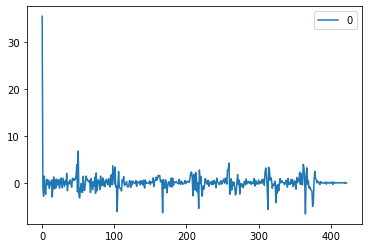

In [86]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

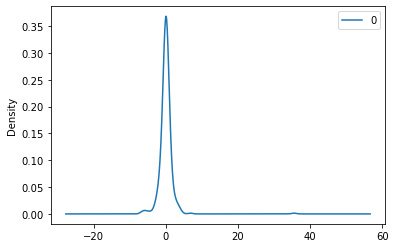

In [87]:
residuals.plot(kind='kde')
pyplot.show()

In [88]:
residuals.describe()

,0
count,423.000000
mean,0.060036
std,2.208202
min,-6.635514
25%,-0.443544
50%,0.024099
75%,0.547323
max,35.530000


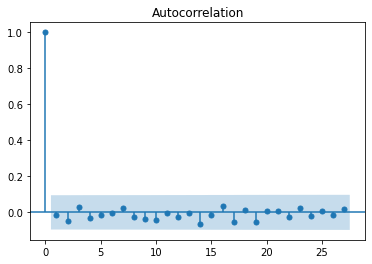

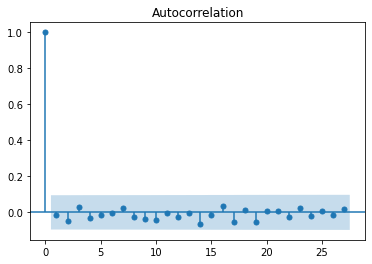

In [89]:
sm.graphics.tsa.plot_acf(residuals.values)

#### The acf plot means the model isn't bad, right?

In [90]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


#Prediction
X = flu_data.pct_positive.values
size = int(len(X) * 0.60)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [91]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=5.661854, expected=5.640000
predicted=6.258425, expected=7.090000
predicted=7.995317, expected=9.030000
predicted=10.249882, expected=10.080000
predicted=11.010707, expected=13.670000
predicted=15.732009, expected=18.880000
predicted=22.213249, expected=26.620000
predicted=32.051190, expected=29.360000
predicted=32.312557, expected=29.350000
predicted=29.801975, expected=30.500000
predicted=30.857771, expected=30.020000
predicted=29.777185, expected=30.170000
predicted=30.261252, expected=29.730000
predicted=29.414198, expected=29.540000
predicted=29.412847, expected=28.460000
predicted=27.808885, expected=25.130000
predicted=23.150483, expected=20.740000
predicted=17.725240, expected=17.980000
predicted=15.685408, expected=17.820000
predicted=17.363075, expected=17.200000
predicted=16.953980, expected=17.220000
predicted=17.274033, expected=14.670000
predicted=13.170025, expected=12.870000
predicted=11.528542, expected=10.840000
predicted=9.351076, expected=9.210000
predicte

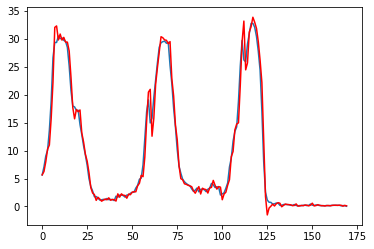

In [92]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()